In [3]:
!pip install pyspark py4j

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=f9683307b36afee5213bd62ae2c24187e55be0cc83ba825bb307e898a7975219
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


**The main libraries to complete the project are about pyspark to manage the dataframes, another libraries as numpy or pandas are necessary to calculate and graph barcharts and results about project.**

In [30]:
import numpy as np
import pandas as pd
import os
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType, StringType
from pyspark.sql.functions import col, count, when, isnan
import matplotlib.pyplot as plt
from pyspark.sql.functions import *
from pyspark.ml.feature import Imputer
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler


from pyspark.sql.functions import round
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

Is mandatory to create a spark session to start with pyspark tools, afterwards, load the csv file and assign to a dataframe in pyspark

In [31]:
#spark = SparkSession.builder.appName("NullValuesAnalysis").getOrCreate()
spark = SparkSession.builder.appName("Treespark").config("spark.driver.memory", "8g").config("spark.executor.memory", "4g").getOrCreate()
# Load the CSV file into a Spark DataFrame
#df = spark.read.option("header", "true").csv("/content/drive/MyDrive/Colab Notebooks/BDFramework/flights-larger.csv")
df = spark.read.csv('/content/drive/MyDrive/Colab Notebooks/BDFramework/flights-larger.csv',
                         sep=',',
                         header=True,
                         inferSchema=True,
                         nullValue='NA')


To start analysis, is fundamental to identify type of data used in this project

In [32]:
print(df.dtypes)

[('mon', 'int'), ('dom', 'int'), ('dow', 'int'), ('carrier', 'string'), ('flight', 'int'), ('org', 'string'), ('mile', 'int'), ('depart', 'double'), ('duration', 'int'), ('delay', 'int')]


Schema shows a descriptive diagram of features in the dataframe

In [33]:
df.printSchema()

root
 |-- mon: integer (nullable = true)
 |-- dom: integer (nullable = true)
 |-- dow: integer (nullable = true)
 |-- carrier: string (nullable = true)
 |-- flight: integer (nullable = true)
 |-- org: string (nullable = true)
 |-- mile: integer (nullable = true)
 |-- depart: double (nullable = true)
 |-- duration: integer (nullable = true)
 |-- delay: integer (nullable = true)



A description of dataframe is showed below, with a summary of statistical descriptions of features

In [34]:
# Check dimensions
print("Rows:", df.count())
print("Columns:", len(df.columns))

# Describe data
df.describe().show()

Rows: 275000
Columns: 10
+-------+------------------+-----------------+------------------+-------+------------------+------+-----------------+------------------+------------------+-----------------+
|summary|               mon|              dom|               dow|carrier|            flight|   org|             mile|            depart|          duration|            delay|
+-------+------------------+-----------------+------------------+-------+------------------+------+-----------------+------------------+------------------+-----------------+
|  count|            275000|           275000|            275000| 275000|            275000|275000|           275000|            275000|            275000|           258289|
|   mean|           5.24232|15.71406909090909| 2.946090909090909|   NULL|2063.0542763636363|  NULL|881.2222872727273|14.124930981817384|151.64103636363637|28.34773064280709|
| stddev|3.4273573316203576|8.805568383848067|1.9635141531217672|   NULL| 2185.852169684581|  NULL|700.51

To identify the type in each feature was necessary to compare with string type, in this way, numerical and categorical columns were identified.

In [35]:
numeric_columns = list()
categorical_columns = list()
for col_ in df.columns:
  if df.select(col_).dtypes[0][1] != "string":
    numeric_columns.append(col_)
  else:
    categorical_columns.append(col_)

print("Numeric columns", numeric_columns)
print("Categorical Columns", categorical_columns)

Numeric columns ['mon', 'dom', 'dow', 'flight', 'mile', 'depart', 'duration', 'delay']
Categorical Columns ['carrier', 'org']


Null values can affect the analysis, one of the options is to drop the null values, however, is possible to lose important information from our dataset, a dataframe with a count of null values and a barchart can help to identify it.

+---+---+---+-------+------+---+----+------+--------+-----+
|mon|dom|dow|carrier|flight|org|mile|depart|duration|delay|
+---+---+---+-------+------+---+----+------+--------+-----+
|  0|  0|  0|      0|     0|  0|   0|     0|       0|16711|
+---+---+---+-------+------+---+----+------+--------+-----+

None
Column 'sum(mon)': 0 null values
Column 'sum(dom)': 0 null values
Column 'sum(dow)': 0 null values
Column 'sum(carrier)': 0 null values
Column 'sum(flight)': 0 null values
Column 'sum(org)': 0 null values
Column 'sum(mile)': 0 null values
Column 'sum(depart)': 0 null values
Column 'sum(duration)': 0 null values
Column 'sum(delay)': 16711 null values


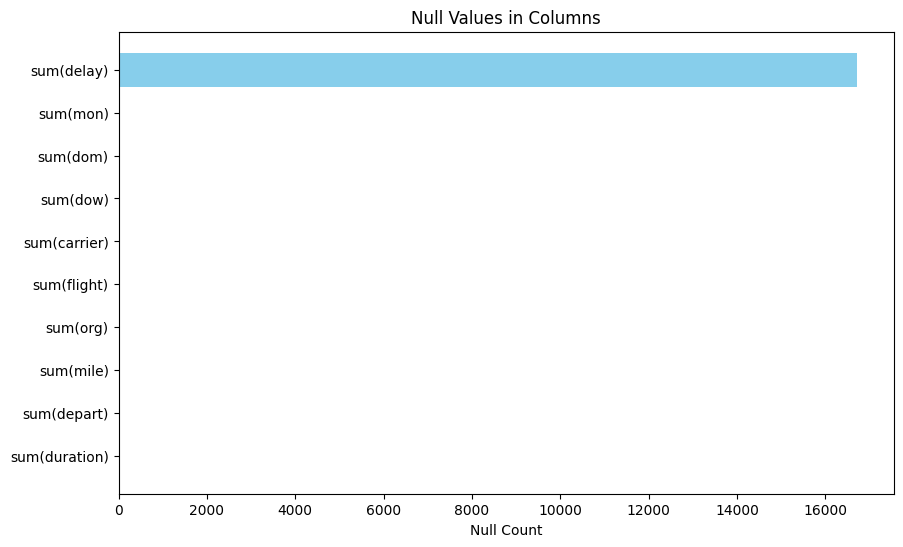

In [36]:
# Count null values in each column
null_counts = df.select([col(c).isNull().cast("int").alias(c) for c in df.columns]).groupBy().sum().collect()[0].asDict()
print(df.select([count(when(isnan(c) | col(c).isNull(),c)).alias(c) for c in df.columns]).show())
# Print null counts
for column, count in null_counts.items():
    print(f"Column '{column}': {count} null values")

# Plot null values
null_counts_df = pd.DataFrame(null_counts.items(), columns=['Column', 'Null Count'])
null_counts_df.sort_values(by='Null Count', ascending=False, inplace=True)

plt.figure(figsize=(10, 6))
plt.barh(null_counts_df['Column'], null_counts_df['Null Count'], color='skyblue')
plt.xlabel('Null Count')
plt.title('Null Values in Columns')
plt.gca().invert_yaxis()
plt.show()

A graph of Average delays by carrier is showed to identify carriers with more delay

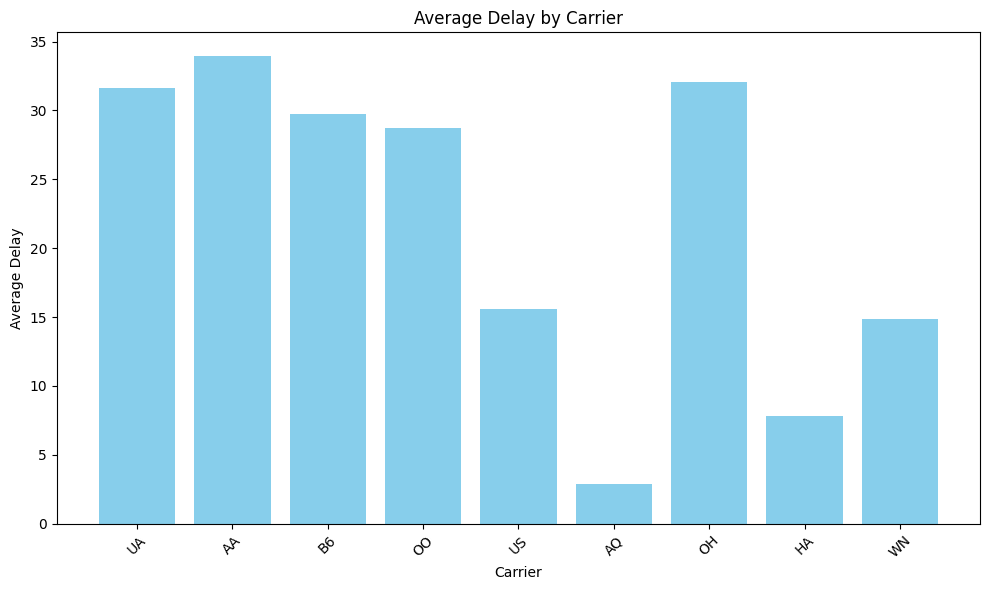

In [37]:
# Grouping delays by carrier
delay_by_carrier = df.groupBy("carrier").agg({"delay": "avg"}).collect()

# Extracting carrier names and delays for plotting
carriers = [row['carrier'] for row in delay_by_carrier]
delays = [row['avg(delay)'] for row in delay_by_carrier]

# Plotting the graph
plt.figure(figsize=(10, 6))
plt.bar(carriers, delays, color='skyblue')
plt.xlabel('Carrier')
plt.ylabel('Average Delay')
plt.title('Average Delay by Carrier')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

Removal of null values was applied in the first proof, however, large of data was reduced and it could be a lack of information

In [38]:
# Remove the 'flight' column
#df =  df.drop('flight') #functional

# Remove records with missing 'delay' values
#flights_valid_delay = flights_drop_column.filter('delay IS NOT NULL')

# Remove records with missing values
#df = df.dropna() #functional
#print(df.count()) #functional


#____________________________________IMPUTER_______________________________#
# Impute null values in the 'delay' column with mean imputation
imputer = Imputer(inputCols=["delay"], outputCols=["delay_imputed"])
model = imputer.setStrategy("mean").fit(df)
df = model.transform(df)

# Show the DataFrame after imputation
df.show()

+---+---+---+-------+------+---+----+------+--------+-----+-------------+
|mon|dom|dow|carrier|flight|org|mile|depart|duration|delay|delay_imputed|
+---+---+---+-------+------+---+----+------+--------+-----+-------------+
| 10| 10|  1|     OO|  5836|ORD| 157|  8.18|      51|   27|           27|
|  1|  4|  1|     OO|  5866|ORD| 466|  15.5|     102| NULL|           28|
| 11| 22|  1|     OO|  6016|ORD| 738|  7.17|     127|  -19|          -19|
|  2| 14|  5|     B6|   199|JFK|2248| 21.17|     365|   60|           60|
|  5| 25|  3|     WN|  1675|SJC| 386| 12.92|      85|   22|           22|
|  3| 28|  1|     B6|   377|LGA|1076| 13.33|     182|   70|           70|
|  5| 28|  6|     B6|   904|ORD| 740|  9.58|     130|   47|           47|
|  1| 19|  2|     UA|   820|SFO| 679| 12.75|     123|  135|          135|
|  8|  5|  5|     US|  2175|LGA| 214|  13.0|      71|  -10|          -10|
|  5| 27|  5|     AA|  1240|ORD|1197| 14.42|     195|  -11|          -11|
|  8| 20|  6|     B6|   119|JFK|1182| 

Mean imputation was used to fill null values, those values were inserted in a new column called **delay_imputed**

In [39]:
from pyspark.sql.functions import isnan, when, col, count
print(df.select([count(when(isnan(c) | col(c).isNull(),c)).alias(c) for c in df.columns]).show())

+---+---+---+-------+------+---+----+------+--------+-----+-------------+
|mon|dom|dow|carrier|flight|org|mile|depart|duration|delay|delay_imputed|
+---+---+---+-------+------+---+----+------+--------+-----+-------------+
|  0|  0|  0|      0|     0|  0|   0|     0|       0|16711|            0|
+---+---+---+-------+------+---+----+------+--------+-----+-------------+

None


In [40]:
unique_delay_count = df.agg(countDistinct("delay").alias("unique_delay_count"))

# Show the count of unique values in the 'delay' column
unique_delay_count.show()

+------------------+
|unique_delay_count|
+------------------+
|               618|
+------------------+



Dataset has a column with miles in flights, for a better understanding of the data, dataframe was modified with a new column with km and miles was deleted from dataset.

In [41]:
# Convert columns 'mile' to 'km' and then drop it
flights_km = df.withColumn('km', round(df.mile * 1.60934, 0)) \
                    .drop('mile')

# Create 'label' column indicating whether a flight is delayed or not
flights_km = flights_km.withColumn('label', (flights_km.delay_imputed >= 15).cast('integer'))

# Check first five records
flights_km.show(5)

+---+---+---+-------+------+---+------+--------+-----+-------------+------+-----+
|mon|dom|dow|carrier|flight|org|depart|duration|delay|delay_imputed|    km|label|
+---+---+---+-------+------+---+------+--------+-----+-------------+------+-----+
| 10| 10|  1|     OO|  5836|ORD|  8.18|      51|   27|           27| 253.0|    1|
|  1|  4|  1|     OO|  5866|ORD|  15.5|     102| NULL|           28| 750.0|    1|
| 11| 22|  1|     OO|  6016|ORD|  7.17|     127|  -19|          -19|1188.0|    0|
|  2| 14|  5|     B6|   199|JFK| 21.17|     365|   60|           60|3618.0|    1|
|  5| 25|  3|     WN|  1675|SJC| 12.92|      85|   22|           22| 621.0|    1|
+---+---+---+-------+------+---+------+--------+-----+-------------+------+-----+
only showing top 5 rows



Carrier and Org features are categorical columns, to manage all the features in a decision tree is necessary convert categorical into numerical columns, the code below shows the conversion in the table.



In [42]:
# Create an indexer, which identifies categories and then creates a new column with numeric index values
flights_indexed = StringIndexer(inputCol='carrier', outputCol='carrier_idx').fit(flights_km).transform(flights_km)

# Repeat the process for org column
flights_indexed = StringIndexer(inputCol='org', outputCol='org_idx').fit(flights_indexed).transform(flights_indexed)
flights_indexed.show(5)

+---+---+---+-------+------+---+------+--------+-----+-------------+------+-----+-----------+-------+
|mon|dom|dow|carrier|flight|org|depart|duration|delay|delay_imputed|    km|label|carrier_idx|org_idx|
+---+---+---+-------+------+---+------+--------+-----+-------------+------+-----+-----------+-------+
| 10| 10|  1|     OO|  5836|ORD|  8.18|      51|   27|           27| 253.0|    1|        2.0|    0.0|
|  1|  4|  1|     OO|  5866|ORD|  15.5|     102| NULL|           28| 750.0|    1|        2.0|    0.0|
| 11| 22|  1|     OO|  6016|ORD|  7.17|     127|  -19|          -19|1188.0|    0|        2.0|    0.0|
|  2| 14|  5|     B6|   199|JFK| 21.17|     365|   60|           60|3618.0|    1|        4.0|    2.0|
|  5| 25|  3|     WN|  1675|SJC| 12.92|      85|   22|           22| 621.0|    1|        3.0|    5.0|
+---+---+---+-------+------+---+------+--------+-----+-------------+------+-----+-----------+-------+
only showing top 5 rows



Decision tree-based models generally work with numerical data. One-hot encoding converts categorical variables into a numerical format, allowing the models to handle nominal categorical variables effectively.

In [48]:
# One-hot encode indexed categorical columns
encoder = [OneHotEncoder(inputCol=col_name+"_idx", outputCol=col_name+"_encoded") for col_name in categorical_columns]
encoder_models = [enc.fit(flights_indexed) for enc in encoder]
df_encoded = flights_indexed
for model in encoder_models:
    df_encoded = model.transform(df_encoded)

df_encoded.show()

+---+---+---+-------+------+---+------+--------+-----+-------------+------+-----+-----------+-------+---------------+-------------+
|mon|dom|dow|carrier|flight|org|depart|duration|delay|delay_imputed|    km|label|carrier_idx|org_idx|carrier_encoded|  org_encoded|
+---+---+---+-------+------+---+------+--------+-----+-------------+------+-----+-----------+-------+---------------+-------------+
| 10| 10|  1|     OO|  5836|ORD|  8.18|      51|   27|           27| 253.0|    1|        2.0|    0.0|  (8,[2],[1.0])|(7,[0],[1.0])|
|  1|  4|  1|     OO|  5866|ORD|  15.5|     102| NULL|           28| 750.0|    1|        2.0|    0.0|  (8,[2],[1.0])|(7,[0],[1.0])|
| 11| 22|  1|     OO|  6016|ORD|  7.17|     127|  -19|          -19|1188.0|    0|        2.0|    0.0|  (8,[2],[1.0])|(7,[0],[1.0])|
|  2| 14|  5|     B6|   199|JFK| 21.17|     365|   60|           60|3618.0|    1|        4.0|    2.0|  (8,[4],[1.0])|(7,[2],[1.0])|
|  5| 25|  3|     WN|  1675|SJC| 12.92|      85|   22|           22| 621.0| 

Outliers can affect the performance of a model, the code below use the indexed columns as a sample to detect and graph outliers.

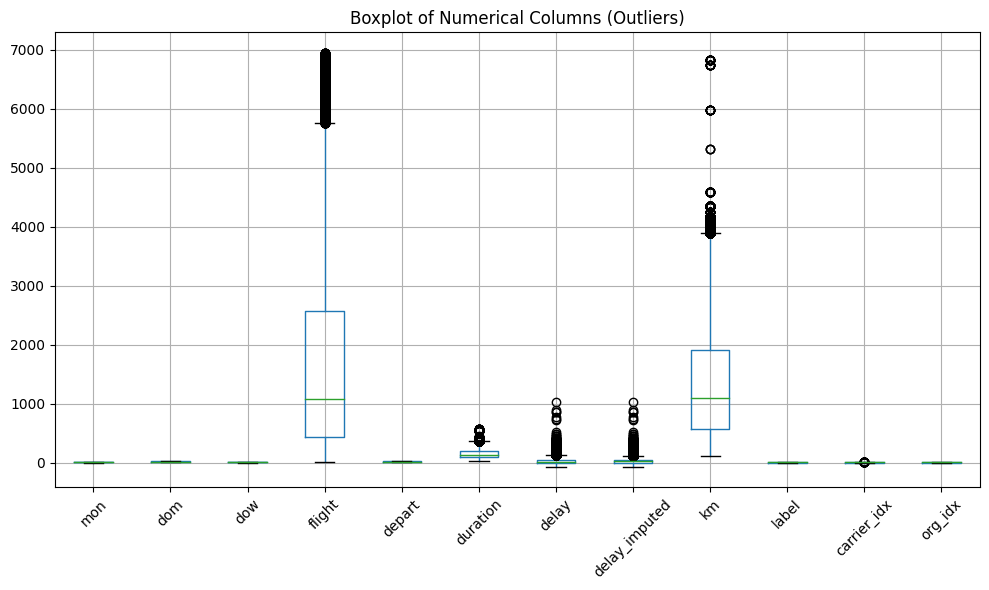

In [45]:
# Sample the combined DataFrame (adjust the fraction as needed)
sampled_df = flights_indexed.sample(withReplacement=False, fraction=0.1, seed=42)  # Adjust fraction as needed

# Convert the sampled DataFrame to Pandas for outlier analysis
pandas_df = sampled_df.toPandas()

# Function to detect outliers using boxplot
def detect_outliers_boxplot(df):
    plt.figure(figsize=(10, 6))
    df.boxplot()
    plt.title('Boxplot of Numerical Columns (Outliers)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Plot boxplot for numerical columns
detect_outliers_boxplot(pandas_df)

PySpark's machine learning algorithms, including decision trees, expect input features to be provided in a single vector column.  VectorAssembler is used to merge multiple feature columns into a single feature vector column, which is the expected input format for PySpark ML algorithms. To build vector assembler, all the features are gathered in a single feature column

In [18]:
# Create an assembler object
assembler = VectorAssembler(inputCols=['mon', 'dom', 'dow',
'carrier_idx', 'org_idx', 'km', 'depart', 'duration'], outputCol='features')
# Consolidate predictor columns
flights_assembled = assembler.transform(flights_indexed)
# Check the resulting column
flights_assembled.select('features', 'delay_imputed').show(5, truncate=False)

+-----------------------------------------+-------------+
|features                                 |delay_imputed|
+-----------------------------------------+-------------+
|[10.0,10.0,1.0,2.0,0.0,253.0,8.18,51.0]  |27           |
|[1.0,4.0,1.0,2.0,0.0,750.0,15.5,102.0]   |28           |
|[11.0,22.0,1.0,2.0,0.0,1188.0,7.17,127.0]|-19          |
|[2.0,14.0,5.0,4.0,2.0,3618.0,21.17,365.0]|60           |
|[5.0,25.0,3.0,3.0,5.0,621.0,12.92,85.0]  |22           |
+-----------------------------------------+-------------+
only showing top 5 rows



as in all machine learning techniques, it is necessary to divide the data into training and test data to build the model. The training_ratio variable then calculates the proportion of records in the training set compared to the total number of records in the original DataFrame (flights_assembled). This ratio is printed to verify that approximately 80% of the data resides in the training set.

In [19]:
# Split into training and testing sets in a 80:20 ratio
flights_train, flights_test = flights_assembled.randomSplit([0.8, 0.2], seed=42)

# Check that training set has around 80% of records
training_ratio = flights_train.count() / flights_assembled.count()
print(training_ratio)

0.7995890909090909


DecisionTreeClassifier() is the funciton used in this project to apply tree decision algorithm to the dataset, after that, a table with label, prediction and probability is depicted to compare prediction and have a better insight of model performance

In [20]:
# Create a DT classifier object and fit to the training data
tree = DecisionTreeClassifier()
tree_model = tree.fit(flights_train)
# Create predictions on test data
prediction = tree_model.transform(flights_test)
prediction.select('label', 'prediction', 'probability').show(5, False)

+-----+----------+---------------------------------------+
|label|prediction|probability                            |
+-----+----------+---------------------------------------+
|0    |1.0       |[0.4635043206471778,0.5364956793528222]|
|1    |1.0       |[0.31742686417032895,0.682573135829671]|
|1    |1.0       |[0.31742686417032895,0.682573135829671]|
|1    |1.0       |[0.40043703906036604,0.599562960939634]|
|1    |1.0       |[0.31742686417032895,0.682573135829671]|
+-----+----------+---------------------------------------+
only showing top 5 rows



To have a better understanding of performance, a correlation matrix is created, parameteres are calculated comparing labels and prediction results, in this way, a count of all comparisons are showed in table below

In [21]:
# Create a confusion matrix
prediction.groupBy('label', 'prediction').count().show()

# Calculate the elements of the confusion matrix
TN = prediction.filter('prediction = 0 AND label = prediction').count()
TP = prediction.filter('prediction = 1 AND label = prediction').count()
FN = prediction.filter('prediction = 0 AND label != prediction').count()
FP = prediction.filter('prediction = 1 AND label != prediction').count()

# Accuracy measures the proportion of correct predictions
accuracy = (TN + TP) / (TN + TP + FN + FP)
print(accuracy)

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0| 8366|
|    0|       0.0|14155|
|    1|       1.0|21175|
|    0|       1.0|11417|
+-----+----------+-----+

0.641046577032642


Using a pyspark function as binaryclassificationEvaluator is able to calculate the model accuracy based on prediction

In [23]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
# Evaluate the model
evaluator = BinaryClassificationEvaluator()
accuracy = evaluator.evaluate(prediction)
print(f"Model accuracy: {accuracy}")

Model accuracy: 0.6242492346520832
